# Modeling spike data with `multidms.jaxmodels`

In [1]:
import multidms
import multidms.jaxmodels

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

Papermill params

In [35]:
replicate = 1
do_truncate_nonsense = True
output_dir = 'output'

reference = 'Omicron_BA1'
l2reg = 1e-3
fusionreg = 0. # 2e-1
block_iters = 20
block_tol = 1e-5

ge_tol = 1e-5
ge_maxiter = 1000
ge_maxls = 30

cal_tol = 1e-5
cal_maxiter = 1000
cal_maxls = 30

loss_fn = "functional_score_loss"
global_epistasis = "Identity"

In [36]:
loss_fn = getattr(multidms.jaxmodels, loss_fn)
global_epistasis = getattr(multidms.jaxmodels, global_epistasis)()

In [4]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Data loading/filtering

Read raw data, pick replicate 1, and aggregate counts

In [5]:
df = pd.read_csv("training_functional_scores_no_agg.csv", keep_default_na=False)

df.query(f"replicate == {replicate}", inplace=True)

# remove deletions
df = df.loc[df.aa_substitutions.str.count("-") < 2, :]

df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
    {"n_subs": "first", "pre_count": "sum", "post_count": "sum"}
    ).reset_index()

df

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count
0,Delta,1,,0,5027212,4967837
1,Delta,1,A1015D,1,978,291
2,Delta,1,A1015D E1188Q,2,796,268
3,Delta,1,A1015D T1027S,2,841,63
4,Delta,1,A1015D T1117C V1176F,3,4,0
...,...,...,...,...,...,...
174106,Omicron_BA2,1,Y91N D138N Q474E,3,217,26
174107,Omicron_BA2,1,Y91N N603I S1252Y,3,792,160
174108,Omicron_BA2,1,Y91T N137T F375T F562L Q804H,5,627,13
174109,Omicron_BA2,1,Y91T S98T A845S L1193P,4,962,63


### Count filtering

Apply some thresholds to filter out low counts. We need pre-counts to be reasonably high to satisfy assumptions of the count-based loss function.

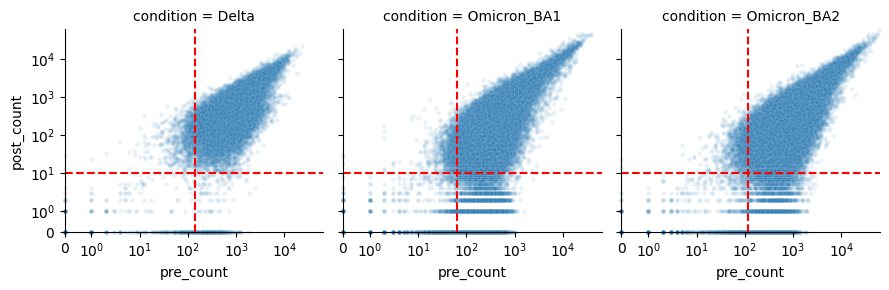

In [6]:
g = sns.relplot(
    x=df.pre_count[df.aa_substitutions != ""],
    y=df.post_count[df.aa_substitutions != ""],
    col=df.condition[df.aa_substitutions != ""],
    s=10, alpha=0.1,
    height=3, aspect=1,
    clip_on=False,
    )
plt.xlim(0, None)
plt.ylim(0, None)
plt.xscale("symlog", linthresh=1, linscale=0.5)
plt.yscale("symlog", linthresh=1, linscale=0.5)

for ax in g.axes.flat:
    condition = ax.get_title().split(" = ")[1]
    df_condition = df.query(f"(condition == @condition) & (aa_substitutions != '')")
    pre_thresh = np.percentile(df_condition.pre_count, 5)
    post_thresh = 10
    df.drop(index=df_condition.query("(pre_count < @pre_thresh) | (post_count < @post_thresh)").index, inplace=True)
    ax.axvline(pre_thresh, color="red", linestyle="--")
    ax.axhline(post_thresh, color="red", linestyle="--")

plt.tight_layout()
plt.show()

### Mutation number filtering

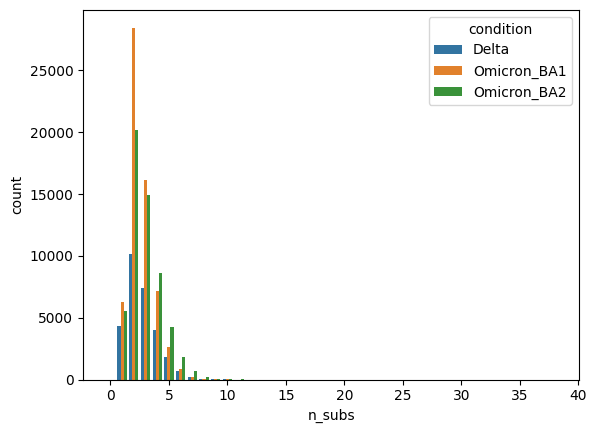

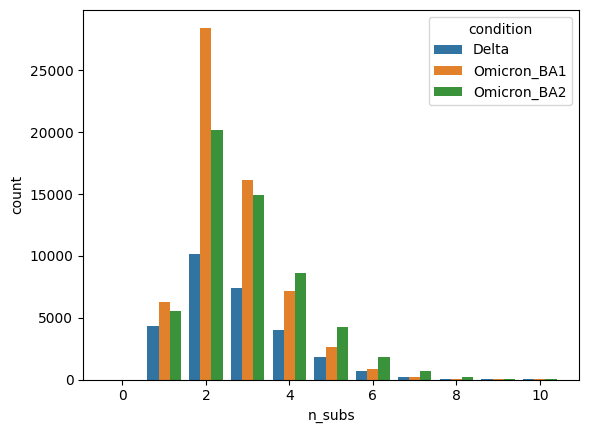

In [7]:
sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.show()

df = df.query("n_subs <= 10")

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.show()


### Nonsense variants

Truncate nonsense variants to exlude any mutations downstream of the first nonsense mutation, and then filter to only nonsense variants with no missense mutation before first nonsense.

In [8]:
def truncate_nonsense(row):
    if row.aa_substitutions:
        muts = row.aa_substitutions.split(" ")
        assert len(muts) == row.n_subs, row
        new_muts = []
        for mut in muts:
            new_muts.append(mut)
            if "*" in mut:
                break
        row.aa_substitutions = " ".join(new_muts)
        row.n_subs = len(new_muts)
    return row

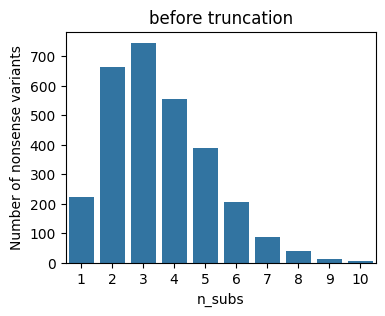

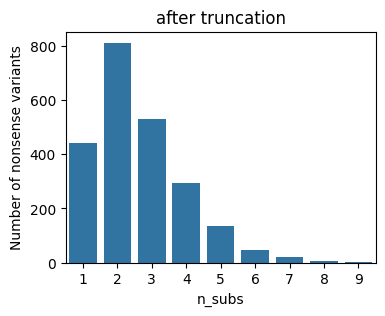

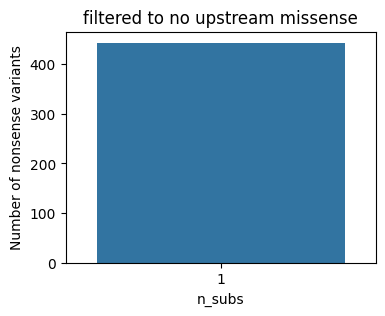

In [9]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("before truncation")
plt.show()

if do_truncate_nonsense:
    df = df.apply(truncate_nonsense, axis=1)
    # re-aggregate identical variants
    df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
        {"n_subs": "first", "pre_count": "sum", "post_count": "sum"}
        ).reset_index()

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("after truncation")
    plt.show()

    df = df.loc[~(df.aa_substitutions.str.contains("*", regex=False) & (df.n_subs > 1)), :]

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("filtered to no upstream missense")
    plt.show()

### Compute functional scores

Note: $\log$ is more natural than $\log_2$ in the fitness-based model

In [10]:
pseudocount = 0.5
df["func_score"] = np.log(df["post_count"] + pseudocount) - np.log(df["pre_count"] + pseudocount)

def group_wt_ref(df_group):
    wts = df_group.query("aa_substitutions == ''")
    assert wts.shape[0] == 1, wts
    df_group.func_score = df_group.func_score.values - wts.func_score.values[0]
    return df_group

df = df.groupby(["condition", "replicate"]).apply(group_wt_ref, include_groups=False).reset_index(level=-1, drop=True).reset_index()

In [11]:
df.shape

(144546, 7)

### Multidms data

Load as a multidms dataset, choosing a reference condition.

In [12]:
multidms_data = multidms.Data(
    df,
    alphabet=multidms.AAS_WITHSTOP_WITHGAP,
    reference=reference,
)

In [13]:
# BA2_numbering = pd.read_csv("https://raw.githubusercontent.com/dms-vep/SARS-CoV-2_Omicron_BA.2_spike_DMS/main/results/site_numbering/site_numbering_map.csv", index_col="reference_site")
# BA2_numbering


# foo = multidms_data.site_map.join(BA2_numbering)

# bad_idxs = foo.Omicron_BA2 != foo.sequential_wt

# foo.loc[bad_idxs, :]

# # BA2_numbering.loc[BA2_numbering.sequential_wt != BA2_numbering.reference_wt, :]

Create a `jaxmodels.Data` object, containing the array data

In [14]:
data_sets = {
    d: multidms.jaxmodels.Data.from_multidms(multidms_data, d)
    for d in multidms_data.conditions
    }

# Display the reference condition data object
data_sets[multidms_data.reference]

Data(
  x_wt=i8[10221],
  pre_count_wt=i64[],
  post_count_wt=i64[],
  X=BCOO(int8[56659, 10221], nse=144684),
  pre_counts=i64[56659],
  post_counts=i64[56659],
  functional_scores=f64[56659]
)

Plot the sums of the binary encodings of the variants

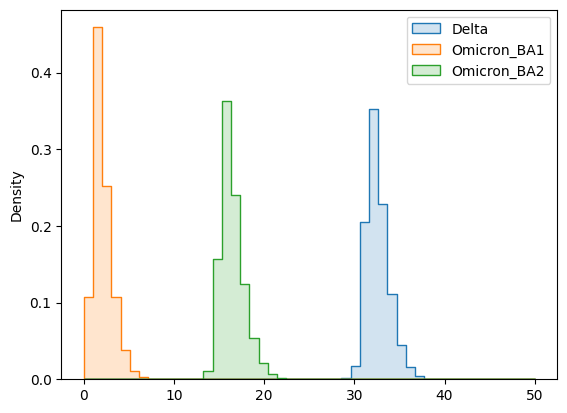

In [15]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.X.sum(1, dtype=float).todense(), label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(0, 50, 50), stat="density")
plt.legend()
plt.show()

Distribution of functional scores

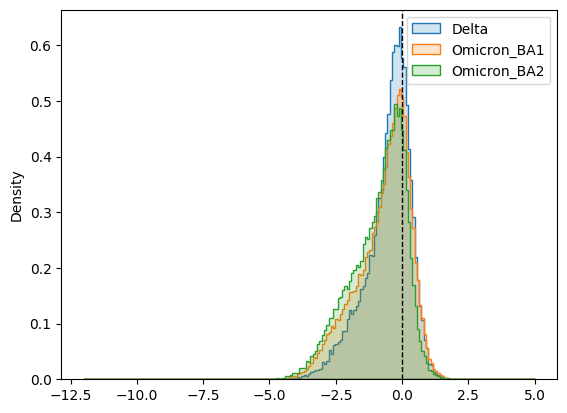

In [16]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.functional_scores, label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(-12, 5, 200), stat="density")
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.legend()
plt.show()

## Fit model

In [37]:
model = multidms.jaxmodels.fit(
    data_sets,
    multidms_data.reference,
    l2reg=l2reg,
    fusionreg=fusionreg,
    block_iters=block_iters,
    block_tol=block_tol,
    ge_kwargs=dict(
        tol=ge_tol,
        maxiter=ge_maxiter,
        maxls=ge_maxls,
        jit=True,
        # verbose=False
        ),
    cal_kwargs=dict(
        tol=cal_tol,
        maxiter=cal_maxiter,
        maxls=cal_maxls,
        jit=True,
        # verbose=False
        ),
    loss_fn=loss_fn,
    global_epistasis=global_epistasis,
    )

iter 1:
  calibration block: error=9.08e-06, stepsize=1.0e+00, iter=16
    Delta: α=1.03, θ=1.00
    Omicron_BA1: α=1.08, θ=1.00
    Omicron_BA2: α=1.09, θ=1.00
  β0 block: error=0.00e+00, stepsize=2.0e+00, iter=1
    Delta: β0=0.17
    Omicron_BA1: β0=-0.15
    Omicron_BA2: β0=-1.02
  β_bundle: error=9.67e-06, stepsize=6.4e+01, iter=138
  β_nonbundle: error=2.28e-05, stepsize=2.6e+02, iter=1000
  Delta sparsity=6.222%
  Omicron_BA2 sparsity=10.068%
  objective_error=5.00e-02
iter 2:
  calibration block: error=3.15e-06, stepsize=1.0e+00, iter=7
    Delta: α=1.03, θ=1.00
    Omicron_BA1: α=1.08, θ=1.00
    Omicron_BA2: α=1.09, θ=1.00
  β0 block: error=0.00e+00, stepsize=2.0e+00, iter=1
    Delta: β0=0.17
    Omicron_BA1: β0=-0.15
    Omicron_BA2: β0=-1.02
  β_bundle: error=9.16e-06, stepsize=6.4e+01, iter=82
  β_nonbundle: error=9.89e-06, stepsize=2.6e+02, iter=68
  Delta sparsity=6.222%
  Omicron_BA2 sparsity=10.068%
  objective_error=1.68e-04
iter 3:
  calibration block: error=7.18e-0

$\beta$ shift distributions

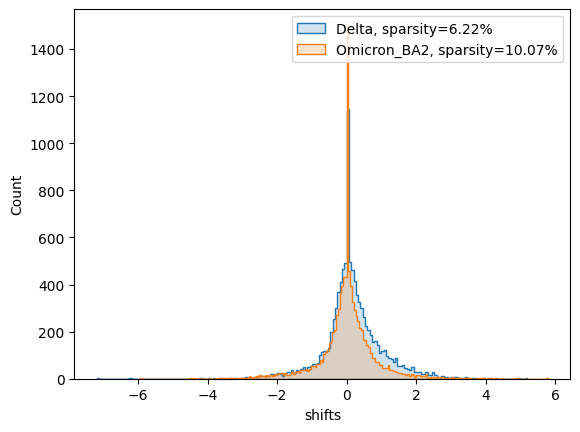

In [38]:
for d in data_sets:
    if d != model.reference_condition:
        shifts = model.φ[d].β - model.φ[model.reference_condition].β
        sns.histplot(
            x=shifts,
            label=f"{d}, sparsity={(shifts == 0).sum() / len(shifts):.2%}", fill=True, alpha=0.2, element="step")
plt.legend()
plt.xlabel("shifts")
plt.show()

Functional score correlations

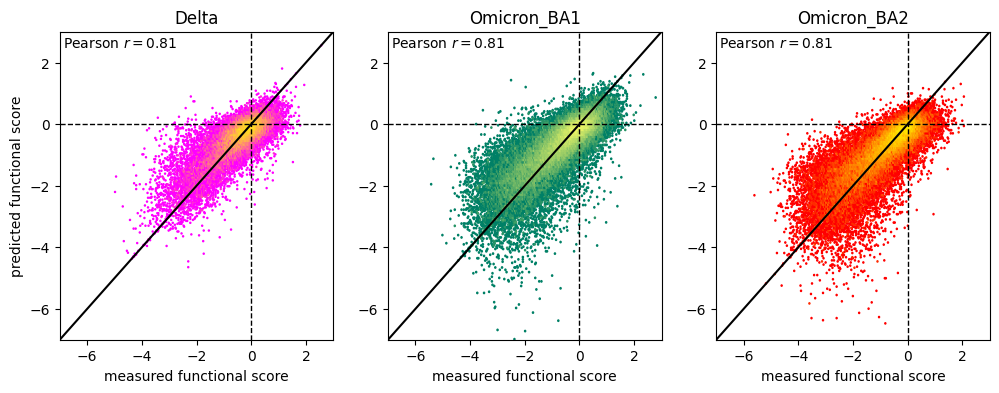

In [39]:
y_preds = model.predict_score(data_sets)

plt.figure(figsize=(12, 4))
ax = None
cmaps = ["spring", "summer", "autumn"]
colors = ["magenta", "green", "red"]
for i, (d, data_set) in enumerate(data_sets.items()):

    X = data_set.X
    x_wt = data_set.x_wt
    y = data_set.functional_scores
    y_pred = y_preds[d]

    ax = plt.subplot(1, 3, i + 1, sharex=ax, sharey=ax)
    plt.hexbin(y, y_pred, cmap=cmaps[i], gridsize=200, bins="log")
    # plt.scatter(y, y_pred, c=colors[i], s=0.1, alpha=0.5)
    plt.annotate(f"Pearson $r={scipy.stats.pearsonr(y, y_pred).statistic:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-10, 4], [-10, 4], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    plt.xlim(-7, 3)
    plt.ylim(-7, 3)
    plt.xlabel("measured functional score")
    if i == 0:
        plt.ylabel("predicted functional score")
    plt.title(d)

plt.show()

Fitness landscape

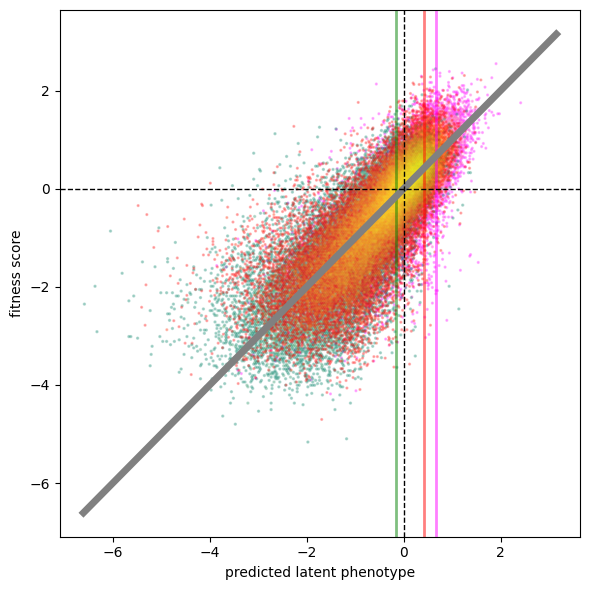

In [40]:
plt.figure(figsize=(6, 6))
φ_min = np.inf
φ_max = -np.inf
for i, (d, data_set) in enumerate(data_sets.items()):
    X = data_set.X
    x_wt = data_set.x_wt
    φ = model.φ[d]
    α = model.α[d]
    φ_pred = φ(X)
    φ_min = min(φ_min, φ_pred.min())
    φ_max = max(φ_max, φ_pred.max())
    φ_pred_wt = φ(x_wt)
    y = data_set.functional_scores
    f = y / α + model.global_epistasis(φ(x_wt))
    # plt.scatter(φ_pred, f, color=colors[i], s=0.1, alpha=0.5)
    plt.hexbin(φ_pred, f, cmap=cmaps[i], bins="log", gridsize=200, alpha=0.25)
    plt.axvline(φ_pred_wt, color=colors[i], lw=2, alpha=0.5)
φ_grid = np.linspace(φ_min, φ_max, 1000)
plt.plot(φ_grid, model.global_epistasis(φ_grid), "grey", lw=5, label=r"$g(\phi)$")
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlabel("predicted latent phenotype")
plt.ylabel("fitness score")
plt.tight_layout()
plt.show()

Joint plots of $\beta$ between conditions

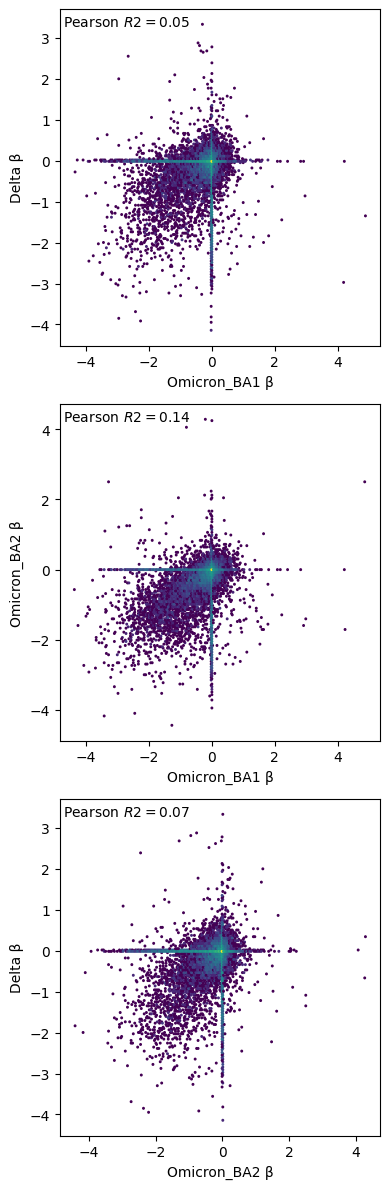

In [41]:
plt.figure(figsize=(4, 12))

plt.subplot(311)
plt.hexbin(model.φ["Omicron_BA1"].β, model.φ["Delta"].β, bins="log", gridsize=200)
r = scipy.stats.pearsonr(model.φ["Omicron_BA1"].β, model.φ["Delta"].β).statistic
plt.annotate(f"Pearson $R2={r**2:.2f}$",
             fontsize=10,
             xy=(0.01, 0.95), xycoords="axes fraction")
# plt.axvline(0, color="black", linestyle="--", lw=1, zorder=0)
# plt.axhline(0, color="black", linestyle="--", lw=1, zorder=0)
plt.xlabel("Omicron_BA1 β")
plt.ylabel("Delta β")

plt.subplot(312)
plt.hexbin(model.φ["Omicron_BA1"].β, model.φ["Omicron_BA2"].β, bins="log", gridsize=200)
r = scipy.stats.pearsonr(model.φ["Omicron_BA1"].β, model.φ["Omicron_BA2"].β).statistic
plt.annotate(f"Pearson $R2={r**2:.2f}$",
             fontsize=10,
             xy=(0.01, 0.95), xycoords="axes fraction")
# plt.axvline(0, color="black", linestyle="--", lw=1, zorder=0)
# plt.axhline(0, color="black", linestyle="--", lw=1, zorder=0)
plt.xlabel("Omicron_BA1 β")
plt.ylabel("Omicron_BA2 β")

plt.subplot(313)
plt.hexbin(model.φ["Omicron_BA2"].β, model.φ["Delta"].β, bins="log", gridsize=200)
r = scipy.stats.pearsonr(model.φ["Omicron_BA2"].β, model.φ["Delta"].β).statistic
plt.annotate(f"Pearson $R2={r**2:.2f}$",
             fontsize=10,
             xy=(0.01, 0.95), xycoords="axes fraction")
# plt.axvline(0, color="black", linestyle="--", lw=1, zorder=0)
# plt.axhline(0, color="black", linestyle="--", lw=1, zorder=0)
plt.xlabel("Omicron_BA2 β")
plt.ylabel("Delta β")


plt.tight_layout()
plt.show()

In [42]:
model.α

{'Delta': Array(1.02785491, dtype=float64),
 'Omicron_BA1': Array(1.08175439, dtype=float64),
 'Omicron_BA2': Array(1.09250188, dtype=float64)}

Distribution of $\beta$

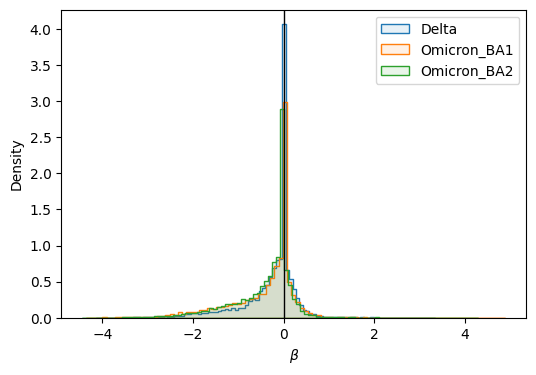

In [43]:
plt.figure(figsize=(6, 4))
for d in model.φ:
    sns.histplot(x=model.φ[d].β, label=d, bins=100, element="step", fill=True, alpha=0.1, stat="density")
plt.axvline(0, color="black", linestyle="-", lw=1)
plt.xlabel(r"$\beta$")
plt.legend()
plt.show()

Compile parameters into dataframe

In [24]:
mutations_df = multidms_data.mutations_df
mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta,times_seen_Omicron_BA1,times_seen_Omicron_BA2
0,M1F,M,1,F,2,0,0
1,M1I,M,1,I,3,1,5
2,M1K,M,1,K,3,0,0
3,M1L,M,1,L,4,0,0
4,M1N,M,1,N,1,0,0


In [25]:
for d in multidms_data.conditions:
    # add betas to mut dataframe
    mutations_df[f"beta_{d}"] = model.φ[d].β
    # add shifts to mut dataframe
    mutations_df[f"shift_{d}"] = model.φ[d].β - model.φ[multidms_data.reference].β

mutations_df.to_csv(f"{output_dir}/mutations_df.csv", index=False)
mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta,times_seen_Omicron_BA1,times_seen_Omicron_BA2,beta_Delta,shift_Delta,beta_Omicron_BA1,shift_Omicron_BA1,beta_Omicron_BA2,shift_Omicron_BA2
0,M1F,M,1,F,2,0,0,-1.225631,-1.225631,0.00000,0.0,0.000000,0.000000
1,M1I,M,1,I,3,1,5,-1.040178,1.271862,-2.31204,0.0,-1.204374,1.107666
2,M1K,M,1,K,3,0,0,-0.933655,-0.933655,0.00000,0.0,0.000000,0.000000
3,M1L,M,1,L,4,0,0,-1.067138,-1.067138,0.00000,0.0,0.000000,0.000000
4,M1N,M,1,N,1,0,0,-1.098786,-1.098786,0.00000,0.0,0.000000,0.000000
